In [1]:
!pip install nvitop

     |████████████████████████████████| 81kB 6.2MB/s 
  Created wheel for nvidia-ml-py: filename=nvidia_ml_py-11.450.51-cp37-none-any.whl size=24235 sha256=07cd68f0fc1ec3730510c07e006d4bec5a50ffda59af45caa80a600a242fc950
  Stored in directory: /root/.cache/pip/wheels/98/bf/a0/2ccfd4ff2f7b98e64f29b57149ddf9cd59d298d583ba9040a3
Successfully built nvidia-ml-py


In [ ]:
!nvitop

Fri Jun 18 16:10:39 2021
╒═════════════════════════════════════════════════════════════════════════════╕
│ NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     │
├───────────────────────────────┬──────────────────────┬──────────────────────┤
│ GPU  Name        Persistence-M│ Bus-Id        Disp.A │ Volatile Uncorr. ECC │
│ Fan  Temp  Perf  Pwr:Usage/Cap│         Memory-Usage │ GPU-Util  Compute M. │
╞═══════════════════════════════╪══════════════════════╪══════════════════════╡
│   0  Tesla T4            Off  │ 00000000:00:04.0 Off │                    0 │
│ N/A   42C    P8      9W / 70W │    128KiB / 15110MiB │      0%      Default │
╘═══════════════════════════════╧══════════════════════╧══════════════════════╛
[ CPU: ██████████████ 40.0%                    ]  ( Load Average: N/A N/A N/A )
[ MEM: ██▎ 6.3%                                ]  [ SWP: ▏ 0%                 ]

╒═════════════════════════════════════════════════════════════════════════════╕
│ Processes:  

In [1]:
import sys
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive')

%reload_ext tensorboard


Mounted at /content/gdrive


In [2]:
!pip install -U albumentations>=0.3.0 --user
!pip install --upgrade git+https://github.com/albumentations-team/albumentations


import albumentations as A

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-fffa2hlz
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-fffa2hlz
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=e2f440a8234583486bf1463ca7738f2810a477df0acd8b2d24d930ed6c6194ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-rmwlamuj/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# custom torch package
import torchkit
from torchkit.run import train, test, fit
from torchkit.data.dataloader import convert
from torchkit.data.dataset import CIFAR_Dataset
from torchkit.utils import data_utils, model_utils
from torchkit.models.cifar_net import SeaFar

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
# Download CIFAR data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Train and Test Transforms 

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4675, 0.4599, 0.4236), mask_fill_value = None),
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])


test_transform = A.Compose(
    [
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])

In [8]:
train = CIFAR_Dataset(trainset.data, trainset.targets, transforms=train_transform)
test = CIFAR_Dataset(testset.data, testset.targets, transforms=test_transform)

train_loader, test_loader = convert(train, test)


In [9]:
class GlobalConfig:
    seed = 1992
    num_classes = 10
    batch_size = 128
    EPOCHS = 70
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data
    input_image_size = (3, 32, 32)
    trainloader = train_loader
    testloader = test_loader

    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



    # model data normalization
    channel_norm = 'BatchNorm2d'
    channel_norm_params = {'GroupNorm': {'num_groups':2},
                 'BatchNorm2d':{'affine':True},
                 'LayerNorm': {'normalized_shape':10}}
                

    # regularizer
    dropout_value = 0.05

    # loss
    loss_function = 'CrossEntropyLoss'

    # scheduler
    lr_scheduler = 'StepLR'
    lr_scheduler_params = {'StepLR': {'step_size':7, 'gamma':0.5},
                
                'ReduceLROnPlateau': {'mode':'min', 'factor':0.5, 'patience':2, 'threshold':0.0001,
                                      'threshold_mode':'rel', 'cooldown':0, 'min_lr':1e-4,
                                      'eps':1e-08, 'verbose':True},
                'OneCycleLR': {'max_lr': 0.2, 'steps_per_epoch':len(trainloader), 'div_factor':20, 'epochs':EPOCHS }}
                                

    # optimizer
    optimizer = 'SGD'
    optimizer_params = {'SGD':{'lr':0.01, 'momentum':0.9}}

    # store model stats
    model_results = {'TestAccuracy': [], 
                  'TrainAccuracy': [],
                  'TestLoss': [],
                  'TrainLoss':[]}

    # Params
    misclassified=True
    L1Lambda=False

    
modelconfig = GlobalConfig


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

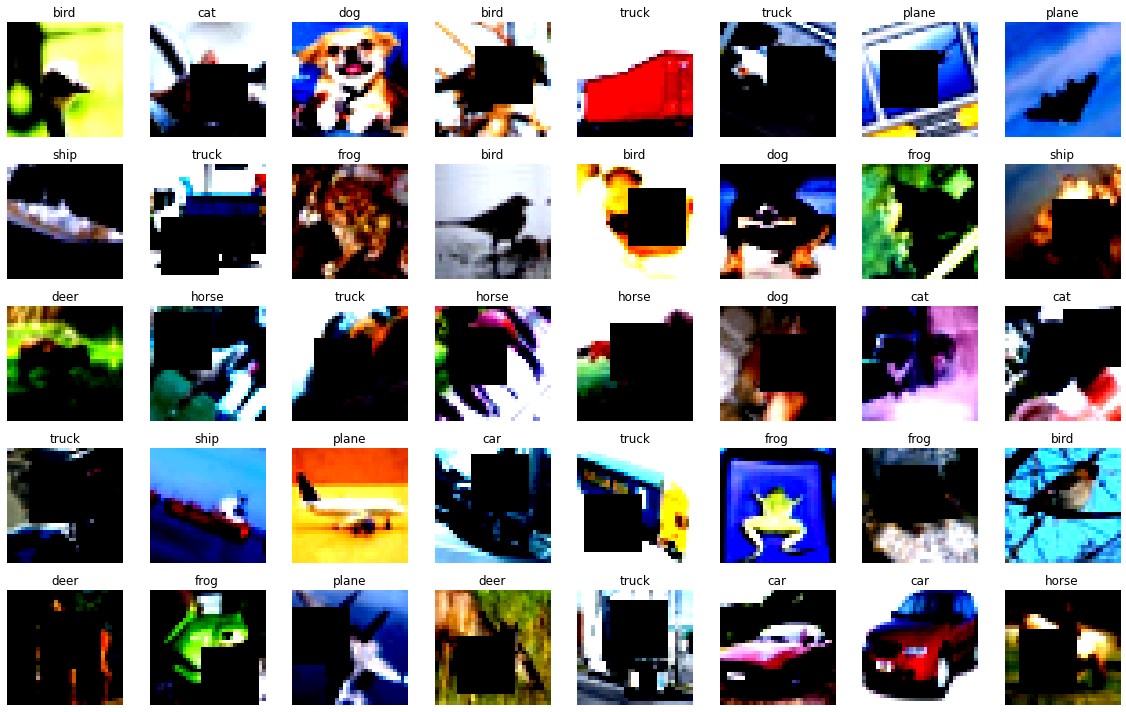

In [10]:
img, label = next(iter(modelconfig.trainloader))
data = CIFAR_Dataset(img,label)
data_utils.plot_data(data,modelconfig)

**Class/Batch Balance**

In [ ]:
from collections import defaultdict
data = defaultdict()
for batch_idx, (images, labels) in enumerate(iter(modelconfig.trainloader)):
  data[batch_idx] = labels

total_data = []
first_batch = data[1]
for i in range(len(data)):
  for label in list(data[i]):
   total_data.append(label.item())

class_balance = defaultdict()
class_data = {0,1,2,3,4,5,6,7,8,9}
for i in class_data:
  class_balance[i]=total_data.count(i)
class_balance



defaultdict(None,
            {0: 5000,
             1: 5000,
             2: 5000,
             3: 5000,
             4: 5000,
             5: 5000,
             6: 5000,
             7: 5000,
             8: 5000,
             9: 5000})

All classes have same number of images, 5000. Dataset is balanced. 

In [ ]:

model = SeaFar(modelconfig).to(modelconfig.device)
summary(model, input_size=modelconfig.input_image_size)
train_misc_img, test_misc_img, model_results = fit(model=model, config=modelconfig)

  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 30, 30]           9,248
            Conv2d-3           [-1, 64, 30, 30]           2,112
              ReLU-4           [-1, 64, 30, 30]               0
       BatchNorm2d-5           [-1, 64, 30, 30]             128
           Dropout-6           [-1, 64, 30, 30]               0
            Conv2d-7           [-1, 64, 15, 15]          36,864
            Conv2d-8           [-1, 32, 15, 15]           2,048
            Conv2d-9           [-1, 48, 15, 15]          13,872
           Conv2d-10           [-1, 48, 13, 13]          20,784
           Conv2d-11           [-1, 64, 13, 13]           3,136
             ReLU-12           [-1, 64, 13, 13]               0
      BatchNorm2d-13           [-1, 64, 13, 13]             128
          Dropout-14           [-1, 64,

Train set: batch_id=390  Average loss: 1.6715997457504272 Accuracy: 32.44: 100%|██████████| 391/391 [00:11<00:00, 35.24it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 4336/10000 (43.36%)


EPOCH:  2 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.4026663303375244 Accuracy: 43.372: 100%|██████████| 391/391 [00:11<00:00, 35.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 5104/10000 (51.04%)


EPOCH:  3 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.419890284538269 Accuracy: 47.984: 100%|██████████| 391/391 [00:11<00:00, 35.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 5623/10000 (56.23%)


EPOCH:  4 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.379957675933838 Accuracy: 51.502: 100%|██████████| 391/391 [00:10<00:00, 35.80it/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6071/10000 (60.71%)


EPOCH:  5 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.3808786869049072 Accuracy: 53.624: 100%|██████████| 391/391 [00:10<00:00, 35.56it/s]


Validation loss has  decreased from 0.0083 to 0.0082. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 6323/10000 (63.23%)


EPOCH:  6 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.1238958835601807 Accuracy: 55.83: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s]


Validation loss has  decreased from 0.0082 to 0.0078. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6467/10000 (64.67%)


EPOCH:  7 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.2141258716583252 Accuracy: 57.294: 100%|██████████| 391/391 [00:11<00:00, 34.90it/s]


Validation loss has  decreased from 0.0078 to 0.0073. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 6768/10000 (67.68%)


EPOCH:  8 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.2461849451065063 Accuracy: 58.672: 100%|██████████| 391/391 [00:11<00:00, 35.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 6387/10000 (63.87%)


EPOCH:  9 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.309148907661438 Accuracy: 60.086: 100%|██████████| 391/391 [00:11<00:00, 34.82it/s]


Validation loss has  decreased from 0.0073 to 0.0069. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6955/10000 (69.55%)


EPOCH:  10 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.0920722484588623 Accuracy: 61.11: 100%|██████████| 391/391 [00:11<00:00, 35.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6903/10000 (69.03%)


EPOCH:  11 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.0626318454742432 Accuracy: 61.998: 100%|██████████| 391/391 [00:11<00:00, 35.09it/s]


Validation loss has  decreased from 0.0069 to 0.0066. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 6993/10000 (69.93%)


EPOCH:  12 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.0298371315002441 Accuracy: 62.638: 100%|██████████| 391/391 [00:11<00:00, 34.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 6958/10000 (69.58%)


EPOCH:  13 LR:  [0.005]


Train set: batch_id=390  Average loss: 0.9759451150894165 Accuracy: 63.134: 100%|██████████| 391/391 [00:11<00:00, 34.90it/s]


Validation loss has  decreased from 0.0066 to 0.0062. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7286/10000 (72.86%)


EPOCH:  14 LR:  [0.005]


Train set: batch_id=390  Average loss: 0.8876146078109741 Accuracy: 64.22: 100%|██████████| 391/391 [00:11<00:00, 34.99it/s]


Validation loss has  decreased from 0.0062 to 0.0059. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7422/10000 (74.22%)


EPOCH:  15 LR:  [0.0025]


Train set: batch_id=390  Average loss: 1.1747570037841797 Accuracy: 64.65: 100%|██████████| 391/391 [00:10<00:00, 35.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7359/10000 (73.59%)


EPOCH:  16 LR:  [0.0025]


Train set: batch_id=390  Average loss: 1.1036765575408936 Accuracy: 65.368: 100%|██████████| 391/391 [00:11<00:00, 34.96it/s]


Validation loss has  decreased from 0.0059 to 0.0057. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7541/10000 (75.41%)


EPOCH:  17 LR:  [0.0025]


Train set: batch_id=390  Average loss: 0.8192383050918579 Accuracy: 66.006: 100%|██████████| 391/391 [00:11<00:00, 35.00it/s]


Validation loss has  decreased from 0.0057 to 0.0056. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7558/10000 (75.58%)


EPOCH:  18 LR:  [0.0025]


Train set: batch_id=390  Average loss: 0.9629412889480591 Accuracy: 65.908: 100%|██████████| 391/391 [00:11<00:00, 34.94it/s]


Validation loss has  decreased from 0.0056 to 0.0054. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7619/10000 (76.19%)


EPOCH:  19 LR:  [0.0025]


Train set: batch_id=390  Average loss: 0.9910710453987122 Accuracy: 66.472: 100%|██████████| 391/391 [00:11<00:00, 34.65it/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7576/10000 (75.76%)


EPOCH:  20 LR:  [0.0025]


Train set: batch_id=390  Average loss: 1.054401159286499 Accuracy: 66.566: 100%|██████████| 391/391 [00:11<00:00, 35.23it/s]


Validation loss has  decreased from 0.0054 to 0.0053. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7688/10000 (76.88%)


EPOCH:  21 LR:  [0.0025]


Train set: batch_id=390  Average loss: 1.1086504459381104 Accuracy: 67.052: 100%|██████████| 391/391 [00:11<00:00, 34.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7645/10000 (76.45%)


EPOCH:  22 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.8655682802200317 Accuracy: 67.472: 100%|██████████| 391/391 [00:11<00:00, 34.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7486/10000 (74.86%)


EPOCH:  23 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.7647688388824463 Accuracy: 67.842: 100%|██████████| 391/391 [00:11<00:00, 34.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7662/10000 (76.62%)


EPOCH:  24 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.8937781453132629 Accuracy: 67.746: 100%|██████████| 391/391 [00:11<00:00, 34.58it/s]


Validation loss has  decreased from 0.0053 to 0.0052. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7764/10000 (77.64%)


EPOCH:  25 LR:  [0.00125]


Train set: batch_id=390  Average loss: 1.234517216682434 Accuracy: 68.122: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s]


Validation loss has  decreased from 0.0052 to 0.005. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7790/10000 (77.90%)


EPOCH:  26 LR:  [0.00125]


Train set: batch_id=390  Average loss: 1.0281951427459717 Accuracy: 68.508: 100%|██████████| 391/391 [00:11<00:00, 34.56it/s]


Validation loss has  decreased from 0.005 to 0.005. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7861/10000 (78.61%)


EPOCH:  27 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.836329460144043 Accuracy: 68.766: 100%|██████████| 391/391 [00:11<00:00, 34.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7752/10000 (77.52%)


EPOCH:  28 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.8713458180427551 Accuracy: 69.1: 100%|██████████| 391/391 [00:11<00:00, 34.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7792/10000 (77.92%)


EPOCH:  29 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.9135953783988953 Accuracy: 69.144: 100%|██████████| 391/391 [00:11<00:00, 34.66it/s]


Validation loss has  decreased from 0.005 to 0.0049. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7900/10000 (79.00%)


EPOCH:  30 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.8505711555480957 Accuracy: 69.748: 100%|██████████| 391/391 [00:11<00:00, 34.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7808/10000 (78.08%)


EPOCH:  31 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.8775336146354675 Accuracy: 69.604: 100%|██████████| 391/391 [00:11<00:00, 34.01it/s]


Validation loss has  decreased from 0.0049 to 0.0049. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7899/10000 (78.99%)


EPOCH:  32 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.9120426177978516 Accuracy: 69.93: 100%|██████████| 391/391 [00:11<00:00, 33.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7885/10000 (78.85%)


EPOCH:  33 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.918443500995636 Accuracy: 70.014: 100%|██████████| 391/391 [00:11<00:00, 34.68it/s]


Validation loss has  decreased from 0.0049 to 0.0047. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7914/10000 (79.14%)


EPOCH:  34 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.8474190831184387 Accuracy: 70.16: 100%|██████████| 391/391 [00:11<00:00, 34.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7904/10000 (79.04%)


EPOCH:  35 LR:  [0.000625]


Train set: batch_id=390  Average loss: 1.1125233173370361 Accuracy: 70.388: 100%|██████████| 391/391 [00:11<00:00, 34.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7971/10000 (79.71%)


EPOCH:  36 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.9031804203987122 Accuracy: 70.714: 100%|██████████| 391/391 [00:11<00:00, 34.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7894/10000 (78.94%)


EPOCH:  37 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.9921013116836548 Accuracy: 70.5: 100%|██████████| 391/391 [00:11<00:00, 33.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7937/10000 (79.37%)


EPOCH:  38 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.6488890051841736 Accuracy: 70.608: 100%|██████████| 391/391 [00:11<00:00, 34.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7810/10000 (78.10%)


EPOCH:  39 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.8991101384162903 Accuracy: 71.124: 100%|██████████| 391/391 [00:11<00:00, 34.44it/s]


Validation loss has  decreased from 0.0047 to 0.0046. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8008/10000 (80.08%)


EPOCH:  40 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.7395986318588257 Accuracy: 71.198: 100%|██████████| 391/391 [00:11<00:00, 34.61it/s]


Validation loss has  decreased from 0.0046 to 0.0045. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8064/10000 (80.64%)


EPOCH:  41 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.6863176822662354 Accuracy: 71.36: 100%|██████████| 391/391 [00:11<00:00, 34.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8035/10000 (80.35%)


EPOCH:  42 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.6401492357254028 Accuracy: 71.302: 100%|██████████| 391/391 [00:11<00:00, 34.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8003/10000 (80.03%)


EPOCH:  43 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.9778555035591125 Accuracy: 71.468: 100%|██████████| 391/391 [00:11<00:00, 34.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8032/10000 (80.32%)


EPOCH:  44 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.7893295884132385 Accuracy: 72.088: 100%|██████████| 391/391 [00:11<00:00, 33.57it/s]


Validation loss has  decreased from 0.0045 to 0.0044. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8074/10000 (80.74%)


EPOCH:  45 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.8204591870307922 Accuracy: 71.94: 100%|██████████| 391/391 [00:11<00:00, 34.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8069/10000 (80.69%)


EPOCH:  46 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.8517694473266602 Accuracy: 71.838: 100%|██████████| 391/391 [00:11<00:00, 34.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8071/10000 (80.71%)


EPOCH:  47 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.5805330276489258 Accuracy: 71.876: 100%|██████████| 391/391 [00:11<00:00, 33.94it/s]


Validation loss has  decreased from 0.0044 to 0.0044. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8152/10000 (81.52%)


EPOCH:  48 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.7011325359344482 Accuracy: 72.034: 100%|██████████| 391/391 [00:11<00:00, 34.15it/s]


Validation loss has  decreased from 0.0044 to 0.0043. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8111/10000 (81.11%)


EPOCH:  49 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 1.0599364042282104 Accuracy: 71.956: 100%|██████████| 391/391 [00:11<00:00, 33.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7998/10000 (79.98%)


EPOCH:  50 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 1.0338435173034668 Accuracy: 72.616: 100%|██████████| 391/391 [00:11<00:00, 34.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8129/10000 (81.29%)


EPOCH:  51 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.6606529951095581 Accuracy: 71.998: 100%|██████████| 391/391 [00:11<00:00, 33.96it/s]


Validation loss has  decreased from 0.0043 to 0.0042. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8110/10000 (81.10%)


EPOCH:  52 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.7329553365707397 Accuracy: 72.442: 100%|██████████| 391/391 [00:11<00:00, 33.83it/s]


Validation loss has  decreased from 0.0042 to 0.0042. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8186/10000 (81.86%)


EPOCH:  53 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.7156457304954529 Accuracy: 72.692: 100%|██████████| 391/391 [00:11<00:00, 34.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8123/10000 (81.23%)


EPOCH:  54 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.6372300982475281 Accuracy: 73.234: 100%|██████████| 391/391 [00:11<00:00, 33.76it/s]
Traceback (most recent call last):


Validation loss has  decreased from 0.0042 to 0.0041. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8165/10000 (81.65%)


EPOCH:  55 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.7555563449859619 Accuracy: 72.708: 100%|██████████| 391/391 [00:11<00:00, 33.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8101/10000 (81.01%)


EPOCH:  56 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.6176298260688782 Accuracy: 72.716: 100%|██████████| 391/391 [00:11<00:00, 34.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8150/10000 (81.50%)


EPOCH:  57 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.6796845197677612 Accuracy: 73.112: 100%|██████████| 391/391 [00:11<00:00, 33.79it/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8172/10000 (81.72%)


EPOCH:  58 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.8723943829536438 Accuracy: 73.064: 100%|██████████| 391/391 [00:11<00:00, 33.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8174/10000 (81.74%)


EPOCH:  59 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.7204220294952393 Accuracy: 73.184: 100%|██████████| 391/391 [00:11<00:00, 33.69it/s]


Validation loss has  decreased from 0.0041 to 0.0041. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8197/10000 (81.97%)


EPOCH:  60 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.736437201499939 Accuracy: 73.522: 100%|██████████| 391/391 [00:11<00:00, 33.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8117/10000 (81.17%)


EPOCH:  61 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.7346717119216919 Accuracy: 73.658: 100%|██████████| 391/391 [00:11<00:00, 33.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8203/10000 (82.03%)


EPOCH:  62 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.8313978910446167 Accuracy: 73.382: 100%|██████████| 391/391 [00:11<00:00, 33.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8199/10000 (81.99%)


EPOCH:  63 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.771901547908783 Accuracy: 73.302: 100%|██████████| 391/391 [00:11<00:00, 33.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8154/10000 (81.54%)


EPOCH:  64 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.6813703775405884 Accuracy: 73.418: 100%|██████████| 391/391 [00:11<00:00, 33.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8149/10000 (81.49%)


EPOCH:  65 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.7875052094459534 Accuracy: 73.852: 100%|██████████| 391/391 [00:11<00:00, 33.58it/s]


Validation loss has  decreased from 0.0041 to 0.0041. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8224/10000 (82.24%)


EPOCH:  66 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.6785708665847778 Accuracy: 73.826: 100%|██████████| 391/391 [00:11<00:00, 34.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8202/10000 (82.02%)


EPOCH:  67 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.8053725361824036 Accuracy: 73.886: 100%|██████████| 391/391 [00:11<00:00, 33.67it/s]


Validation loss has  decreased from 0.0041 to 0.004. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8252/10000 (82.52%)


EPOCH:  68 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.8220790028572083 Accuracy: 73.576: 100%|██████████| 391/391 [00:11<00:00, 33.96it/s]


Validation loss has  decreased from 0.004 to 0.004. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8307/10000 (83.07%)


EPOCH:  69 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.795085072517395 Accuracy: 74.138: 100%|██████████| 391/391 [00:11<00:00, 33.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8228/10000 (82.28%)


EPOCH:  70 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.7126436829566956 Accuracy: 74.25: 100%|██████████| 391/391 [00:11<00:00, 33.72it/s]


Validation loss has  decreased from 0.004 to 0.0039. Saving the model

Test set: Average loss: 0.0039, Accuracy: 8291/10000 (82.91%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

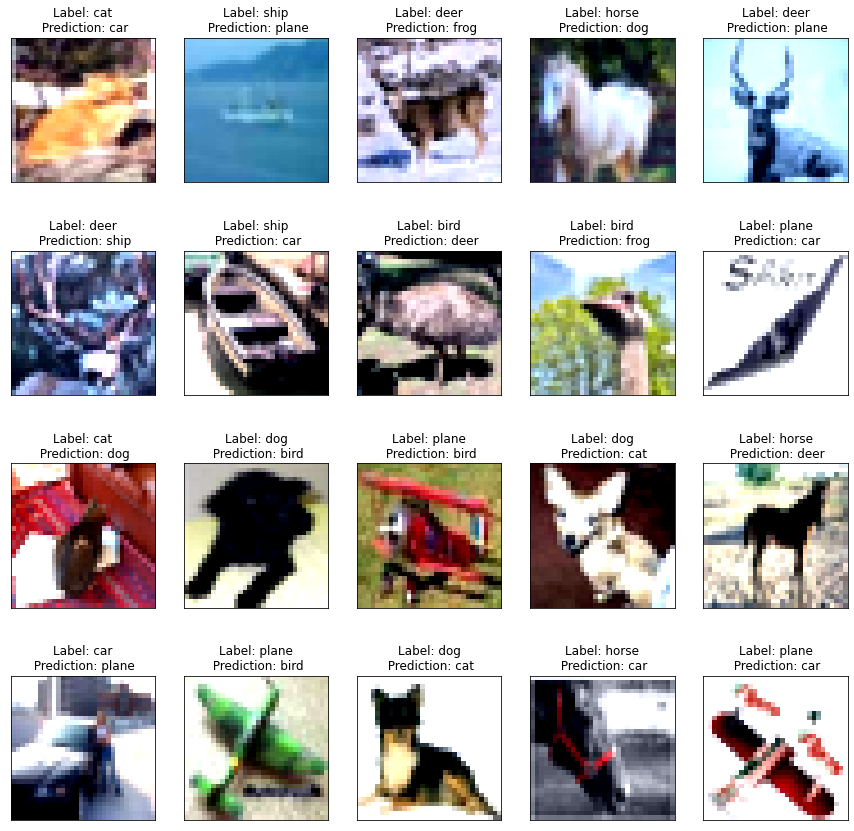

In [ ]:
test_misc_images = [test_misc_img[i] for i in range(20)]
data_utils.plot_misclassified_rgb(test_misc_images, 'test_misc_batchnorm.png', config=modelconfig)

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in modelconfig.testloader:
        images, labels = data
        labels=labels.to(modelconfig.device)
        outputs = model(images.to(modelconfig.device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        modelconfig.classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 80 %
Accuracy of   cat : 62 %
Accuracy of  deer : 96 %
Accuracy of   dog : 79 %
Accuracy of  frog : 96 %
Accuracy of horse : 86 %
Accuracy of  ship : 100 %
Accuracy of truck : 83 %


In [ ]:
len(modelconfig.testloader)

79

In [ ]:
_results = modelconfig.model_results
testacc =  _results['TestAccuracy']
trainacc =  _results['TrainAccuracy']
testloss = [i/len(modelconfig.testloader) for i in _results['TestLoss']]
trainloss = [i/len(modelconfig.trainloader) for i in _results['TrainLoss']]

# testacc = model_results['TestAccuracy']
# trainacc = model_results['TrainAccuracy']
# testloss = model_results['TestLoss']
# trainloss = model_results['TrainLoss']
# _results

In [ ]:
len(testacc)

70

In [ ]:
plot_details_dict = {'Test Accuracy(%)': 'Validation Accuracy',
                     'Train Accuracy(%)': 'Train Accuracy',
                     'Test Loss(%)': 'Validation Loss',
                     'Train Loss(%)': 'Train Loss'}


def plot_curve(data, y_label):
  # Plotting both the curves simultaneously
  with plt.style.context('dark_background'):# fivethirtyeight
    plt.plot(data[0:70], color='r', label='BatchNorm')
    
    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(plot_details_dict[y_label])
      
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
  

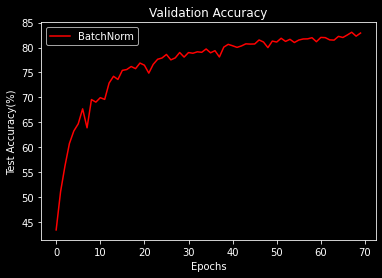

In [ ]:
plot_curve(testacc, "Test Accuracy(%)")

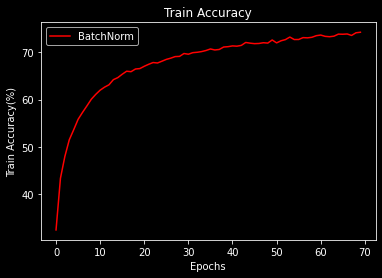

In [ ]:
plot_curve(trainacc, "Train Accuracy(%)")

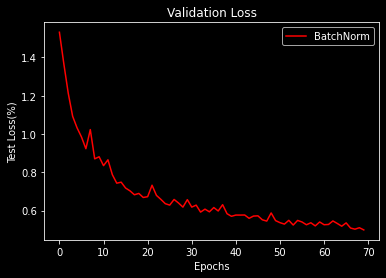

In [ ]:
plot_curve(testloss, "Test Loss(%)")

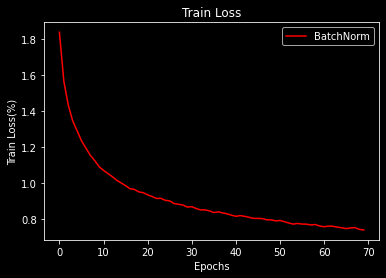

In [ ]:
plot_curve(trainloss, "Train Loss(%)")